## Preferences Analysis

This notebook will use the merged dataset created from the device logger and preferences data sets to get a better idea of the underlying data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display_html

In [35]:
dir = Path(os.getcwd())
prefs = pd.read_csv(dir/'merged_preferences.csv', parse_dates=['synced_timestamp'])

uu = len(prefs['user_id'].unique())
print(f'Number of unique users: {uu}')

ua = len(prefs['item_id'].unique())
print(f'Number of unique pieces of art: {ua}')

ua_rec = len(prefs[pd.notnull(prefs['target'])].item_id.unique())
print(f'Number of unique art pieces recommended to users: {ua_rec}')

res_total = prefs.shape[0]
print(f'Total number of responses: {res_total}')

percent_positive = round((prefs.loc[prefs['pref'] == True].shape[0] / res_total) * 100, 2)
print(f'Total percent of positive response: {percent_positive}')

ti = prefs.loc[prefs['target'].notnull()].loc[prefs['target'] == True].shape[0]
print(f"Total number of responses for target items: {ti}")

ti_nt = prefs.loc[prefs['target'].notnull()].loc[prefs['target'] == False].shape[0]
print(f"Total number of responses for items that weren't the target: {ti_nt}")

anr = round(prefs.shape[0]/len(prefs['user_id'].unique()), 2)
print(f'Average number of responses per user: {anr}')

total_items = list(prefs['item_id'].unique())
survey_items = list(prefs[prefs['user_id'].str.startswith('admin')].item_id.unique())
non_survey_items = list(prefs[~prefs['user_id'].str.startswith('admin')].item_id.unique())
# making sure the totals add up correctly
assert len(non_survey_items) + len([i for i in survey_items if i not in non_survey_items]) == len(total_items)

only_survey_items = len([i for i in survey_items if i not in non_survey_items])
print(f'Art pieces with responses only from training survey: {only_survey_items}')

Number of unique users: 757
Number of unique pieces of art: 181
Number of unique art pieces recommended to users: 137
Total number of responses: 3155
Total percent of positive response: 70.11
Total number of responses for target items: 187
Total number of responses for items that weren't the target: 1626
Average number of responses per user: 4.17
Art pieces with responses only from training survey: 40


In total, there are 757 unique user ids, 181 unique art piece ids, and 137 unique art ids that were recommended to users, out of 3,155 responses. There are also 40 art pieces that have responses only from the training survey, which make up about 22% of the total art pieces in the data. On a side note, the number of unique pieces of art matches the number of pieces listed in the artwork_data.csv file.

Text(0, 0.5, 'Frequency')

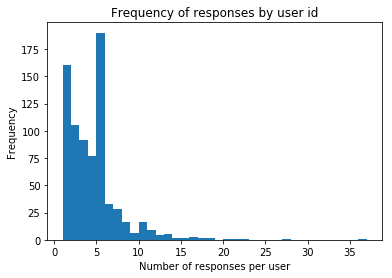

In [79]:
prefs.groupby(['user_id']).size().hist(bins=36, grid=False)
plt.title('Frequency of responses by user id')
plt.xlabel('Number of responses per user')
plt.ylabel('Frequency')

There are over 150 cases where a user only responded to one item. These cases won't be useful to a recommender engine since they don't provide a wide history of responses. We can test recommender with and without these cases to see if there is an improvement. Otherwise, the vast majority of users responded to 5 pieces of art or less.

Now, let's look into the peak times the devices were used and average time between uses. Based on the date time data formats in the logger JSON and preferences CSV, it looks like the dates are stored in UTC timezone. First, need to convert those to US Central timezone.

Text(0, 0.5, 'Frequency')

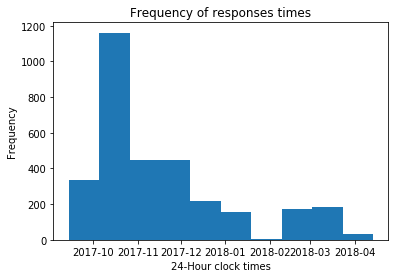

In [4]:
converted_hours = prefs.synced_timestamp.dt.tz_localize('utc').dt.tz_convert('US/Central')
converted_hours.dt.hour
converted_hours.hist(grid=False)
plt.title('Frequency of responses times')
plt.xlabel('24-Hour clock times')
plt.ylabel('Frequency')

Looks like most responses occur between noon and 2pm, then fall off and pick back up between 6pm and close at 9pm. The MIA closes at 9pm, though, so it is a bit suspicious to have so many values after 9pm. Perhaps they are from the admin survey. Let's remove those and see.

Text(0, 0.5, 'Frequency')

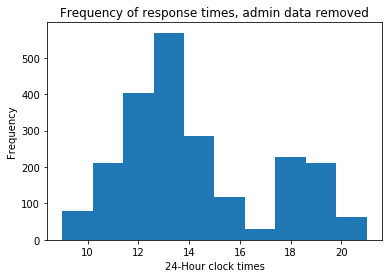

In [5]:
non_admin_conv = prefs[~prefs['user_id'].str.startswith('admin')].synced_timestamp.dt.tz_localize('utc').dt.tz_convert('US/Central')
non_admin_hours = non_admin_conv.dt.hour
non_admin_hours.hist(grid=False)
plt.title('Frequency of response times, admin data removed')
plt.xlabel('24-Hour clock times')
plt.ylabel('Frequency')

There are still some from after 9pm, but much fewer. Minus the values past 9pm, the converted hours make sense and follow the same general distribution as with the admin data.

More insight can be found from looking into the actual user preferences.

In [6]:
# grouping by art id, preference and reformatting for clarity before pivoting for True/False columns
def group_by_ratings(df):
    df_prefs = df.groupby(['item_id', 'pref']).size().reset_index().rename(columns={0:'count'})
    df_prefs = df_prefs.pivot(index='item_id', columns='pref')['count'].fillna(0).reset_index()
    df_prefs = df_prefs.rename(columns={True:'True', False: 'False'})
    df_prefs['percent approve'] = df_prefs['True'] / (df_prefs['True'] + df_prefs['False'])
    return df_prefs

art_prefs = group_by_ratings(prefs)
art_prefs.head()

pref,item_id,False,True,percent approve
0,44,1.0,18.0,0.947368
1,45,2.0,8.0,0.800000
2,47,0.0,5.0,1.000000
3,53,4.0,8.0,0.666667
4,136,24.0,27.0,0.529412


In [7]:
# doing the same grouping as above, but subsetting survey and non-survey groups and appending
def subset_by_type_and_append(df, append_df, column_name):
    t_name = f'True, {column_name}'
    f_name = f'False, {column_name}'
    pa_name = f'percent approve, {column_name}'
    df_a = append_df.groupby(['item_id', 'pref']).size().reset_index().rename(columns={0:'count'})
    df_a = df_a.pivot(index='item_id', columns='pref')['count'].fillna(0).reset_index()
    df_a = df_a.rename(columns={True: t_name, False: f_name})
    df_a[pa_name] = df_a[t_name] / (df_a[t_name] + df_a[f_name])
    return pd.merge(df, df_a[['item_id', pa_name]], how='left', on=['item_id'])

subset1 = prefs[prefs['user_id'].str.startswith('admin')]
subset2 = prefs[~prefs['user_id'].str.startswith('admin')]
art_prefs = subset_by_type_and_append(art_prefs, subset1, 'survey preferences')
art_prefs = subset_by_type_and_append(art_prefs, subset2, 'non survey preferences')
art_prefs.head()

pref,item_id,False,True,percent approve,"percent approve, survey preferences","percent approve, non survey preferences"
0,44,1.0,18.0,0.947368,1.000000,0.923077
1,45,2.0,8.0,0.800000,0.714286,1.000000
2,47,0.0,5.0,1.000000,1.000000,NaN
3,53,4.0,8.0,0.666667,0.500000,0.833333
4,136,24.0,27.0,0.529412,0.666667,0.511111


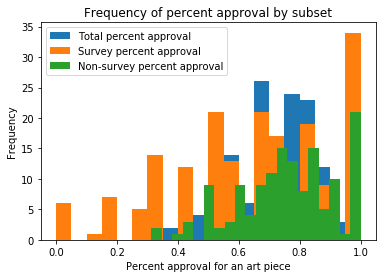

In [8]:
# plotting a frequency histogram of total and subsetted groups
art_prefs['percent approve'].hist(grid=False, bins=20, label='Total percent approval')
art_prefs['percent approve, survey preferences'].hist(grid=False, bins=20, label='Survey percent approval')
art_prefs['percent approve, non survey preferences'].hist(grid=False, bins=20, label='Non-survey percent approval')
plt.xlabel('Percent approval for an art piece')
plt.ylabel('Frequency')
plt.title('Frequency of percent approval by subset')
plt.legend()

In [9]:
print('Average and median preference in training group:')
avg = art_prefs['percent approve, survey preferences'].mean()
med = art_prefs['percent approve, survey preferences'].median()
print(f'Average: {avg}')
print(f'Median: {med}')
print('')
print('Average and median preference in non-training group')
avg = art_prefs['percent approve, non survey preferences'].mean()
med = art_prefs['percent approve, non survey preferences'].median()
print(f'Average: {avg}')
print(f'Median: {med}')

Average and median preference in training group:
Average: 0.6382142857142856
Median: 0.6666666666666666

Average and median preference in non-training group
Average: 0.760924183358555
Median: 0.7692307692307693


After subsetting the data into the percent of participants who approved a given art piece between the training survey and non-training survey, there seems to be a pattern where the training survey participants were more likely to rate a piece of art unfavorably. Perhaps the most unfavorable pieces of art from the survey were not included in the recommendations for the open groups, which would explain why there are 40 pieces of art in the training group that do not have any records in the other groups. We can subset the data again and see if that's the case.

In [80]:
# these variables are from original subsets above
survey_only_items = [i for i in survey_items if i not in non_survey_items]

print('Average and median of art pieces only found in training group:')
avg = art_prefs[art_prefs.item_id.isin(survey_only_items)]['percent approve, survey preferences'].mean()
med = art_prefs[art_prefs.item_id.isin(survey_only_items)]['percent approve, survey preferences'].median()
print(f'Average: {avg}')
print(f'Median: {med}')
print('')

shared_items = [i for i in survey_items if i not in survey_only_items]
print('Average and median of art pieces in training group that are shared with non-training group:')
avg = round(art_prefs[art_prefs.item_id.isin(shared_items)]['percent approve, survey preferences'].mean() * 100, 2)
med = round(art_prefs[art_prefs.item_id.isin(shared_items)]['percent approve, survey preferences'].median() * 100, 2)
print(f'Average: {avg}')
print(f'Median: {med}')


Average and median of art pieces only found in training group:
Average: 0.6179761904761905
Median: 0.6

Average and median of art pieces in training group that are shared with non-training group:
Average: 64.4
Median: 66.67


There's not much difference between the average and median values of art pieces only found in the training data and those that were shared. Next, we can compare art pieces by medium and time period, but first we can do one more subset to find how many participants rated a target piece favorably. 

In [33]:
target_data = prefs[prefs['target'].notnull()][prefs['target'] == True]
target_prefs = group_by_ratings(target_data)

print('Average and median of target art pieces ratings:')
avg = target_prefs['percent approve'].mean()
med = target_prefs['percent approve'].median()
print(f'Average: {avg}')
print(f'Median: {med}')
ttt = target_prefs.shape[0]
print(f'Total target items: {ttt}')
target_prefs['count'] = target_prefs['False'] + target_prefs['True']
mto = target_prefs[target_prefs['count'] > 1].shape[0]
print(f'Target items with more than one rating: {mto}')


Average and median of target art pieces ratings:
Average: 0.6210702341137124
Median: 0.75
Total target items: 92
Target items with more than one rating: 32


/mnt/c/Users/Mike/Documents/divrods_project/divrods/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


The mean is fairly skewed toward negative ratings, but the median shows a fairly positive score of 75%, which indicates that half of the target pieces of art had at least 75% of participants rate the peice favorably. Next, let's incorporate more data on each art piece and subset preferences by new categories.

In [72]:
# first, merging over the data pulled from the MIA's elasticsearch into the art_prefs dataframe
art_df = pd.read_csv(dir/'extended_artwork_data.csv').rename(columns={'id': 'item_id'})
ap_merged = pd.merge(art_prefs, art_df[['item_id', 'style', 'classification']], how='left',
                   on=['item_id'])

classifications = ap_merged['classification'].unique()
class_df = pd.DataFrame(index = classifications, columns=['Percent approval', 'Total responses'])
styles = ap_merged['style'].unique()
styles_df = pd.DataFrame(index = styles, columns=['Percent approval', 'Total responses'])
counts = prefs.groupby(['item_id', 'pref']).size().reset_index().rename(columns={0:'count'})


for c in classifications:
    c_df = ap_merged[ap_merged['classification'] == c]
    class_df.loc[c, :]['Percent approval'] = round(c_df['percent approve'].mean() * 100, 2)
    class_df.loc[c, :]['Total responses'] = c_df['False'].sum() + c_df['True'].sum()

for s in styles:
    s_df = ap_merged[ap_merged['style'] == s]
    styles_df.loc[s, :]['Percent approval'] = round(s_df['percent approve'].mean() * 100, 2)
    styles_df.loc[s, :]['Total responses'] = s_df['False'].sum() + s_df['True'].sum()


In [71]:
# note: this function came directly from StackOverflow, it overrides the CSS of Juypter Notebook to 
# display tables side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(class_df.sort_values(by=['Total responses'], ascending=False), 
                     styles_df.sort_values(by=['Total responses'], ascending=False))

,Percent approval,Total responses
Paintings,71.94,1266
Sculpture,69.75,648
Textiles,70.54,333
Furniture,64.71,266
Ceramics,60.8,190
Prints,68.57,141
Metalwork,66.25,119
Drawings,69.87,43
Architecture,70.32,34
Photographs,76.04,28


Keeping in mind the overall percent of positive ratings, 70%, most categories fall around that baseline. There are only a few categories that have over 50 responses and have a percentage of positive ratings at least 5% lower than the baseline - Ceramics and Furniture. There were far more categories that received a percent positive rating less than 5% while having at least 50 responses in the 'styles' key from the MIA's Elasticsearch. Artwork from the 16th Century was rated the most unfavorably at 53% positive rating, meaning the chance someone will view a piece from that category favorably is slightly higher than a coin flip. The 18th and 15th century pieces did not fare much better, while 20th and 21st century pieces carried the highest favorability.